<a href="https://colab.research.google.com/github/tkkkkkz/Data_Science_Projects/blob/main/Agriculture_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# read data
import pandas as pd
import numpy as np
import json

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import geopy

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

## 1. Import Data

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
annotaion_link = '/content/gdrive/My Drive/Colab Notebooks/Blue River/test_annotation_table.csv'
image_link = '/content/gdrive/My Drive/Colab Notebooks/Blue River/test_image_table.csv'

In [4]:
annotation = pd.read_csv(annotaion_link,sep=';')
image = pd.read_csv(image_link,sep=';')

In [5]:
annotation.head()

,id,creation_date,updated_date,bounding_boxes,style,review_state,project_id,image_id
0,505005,2019-08-29 19:38:26.358428,NaN,NaN,pixelwise,ok,1,505005
1,1467202,2019-11-25 09:36:45.527169,NaN,NaN,pixelwise,ok,1,1467202
2,1224367,2019-11-09 05:31:17.791272,NaN,NaN,pixelwise,ok,1,1224367
3,1058595,2019-11-01 04:01:21.444399,NaN,NaN,pixelwise,ok,1,1058595
4,829150,2019-10-15 22:41:53.130787,NaN,NaN,pixelwise,ok,1,829150


In [6]:
annotation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              30000 non-null  int64 
 1   creation_date   30000 non-null  object
 2   updated_date    9532 non-null   object
 3   bounding_boxes  424 non-null    object
 4   style           30000 non-null  object
 5   review_state    30000 non-null  object
 6   project_id      30000 non-null  int64 
 7   image_id        30000 non-null  int64 
dtypes: int64(3), object(5)
memory usage: 1.8+ MB


In [7]:
image.head()

,id,collection_date,machine_data,content_hash,image_id
0,2548046,2019-08-05 20:45:05.115711,"{""ils_nir"": 1142, ""ils_red"": 1896, ""weather"": ...",109d6a4af9a5fc7c21ceee2168063209,2548046
1,3712464,2019-06-10 17:22:05.576691,"{""ils_nir"": 1176, ""ils_red"": 1982, ""weather"": ...",c9ffe3381de6ad8b01853fd62779daef,3712464
2,4322340,2019-07-11 15:02:04.521867,"{""ils_nir"": 1999, ""ils_red"": 2953, ""weather"": ...",922f5cb720b61d617d97d8471c3063e1,4322340
3,3910126,2019-05-16 20:19:07.538567,"{""ils_nir"": 1531, ""ils_red"": 2554, ""weather"": ...",5d63b064497d24121557f805a6257209,3910126
4,3424603,2019-06-21 18:54:55.987010,"{""ils_nir"": 265, ""ils_red"": 477, ""weather"": ""o...",f28f7ea4e4dbb3c7cedab5aed4d9458e,3424603


In [8]:
image.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               30000 non-null  int64 
 1   collection_date  30000 non-null  object
 2   machine_data     30000 non-null  object
 3   content_hash     30000 non-null  object
 4   image_id         30000 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 1.1+ MB


There are dictionaries in 'machine_data'. I will first need to parse 'machine_data' into several features that could be useful for my following analysis. 

In [9]:
# parse machine_data
machine_data_df = image.machine_data.apply(json.loads).apply(pd.Series)

# the features that I am interested in machine_data
parse_columns = ['crop_name', 'robot_name', 'weed_pressure', 'furrow_depth_inches', 'gps_latitude', 'gps_longitude']

for column in parse_columns:
  image[column] = machine_data_df[column]

In [10]:
# extract date-time info from 'collection_date'
image['date'] = pd.to_datetime(image.collection_date).dt.date
image['week'] = pd.to_datetime(image.collection_date).dt.week
image['year'] = pd.to_datetime(image.collection_date).dt.year

# since I will only consider the data in 2019, therefore, I will mainly use image_2019 in the following
image_2019 = image[image['year']==2019]
image_2019.head()

,id,collection_date,machine_data,content_hash,image_id,crop_name,robot_name,weed_pressure,furrow_depth_inches,gps_latitude,gps_longitude,date,week,year
0,2548046,2019-08-05 20:45:05.115711,"{""ils_nir"": 1142, ""ils_red"": 1896, ""weather"": ...",109d6a4af9a5fc7c21ceee2168063209,2548046,cotton,dcm-fig,high,zerototwoinches,32.242079,-101.954649,2019-08-05,32,2019
1,3712464,2019-06-10 17:22:05.576691,"{""ils_nir"": 1176, ""ils_red"": 1982, ""weather"": ...",c9ffe3381de6ad8b01853fd62779daef,3712464,cotton,dcm-date,medium,zerototwoinches,33.956683,-102.599881,2019-06-10,24,2019
2,4322340,2019-07-11 15:02:04.521867,"{""ils_nir"": 1999, ""ils_red"": 2953, ""weather"": ...",922f5cb720b61d617d97d8471c3063e1,4322340,soybeans,dcm-cherry,low,zerototwoinches,0.000000,0.000000,2019-07-11,28,2019
3,3910126,2019-05-16 20:19:07.538567,"{""ils_nir"": 1531, ""ils_red"": 2554, ""weather"": ...",5d63b064497d24121557f805a6257209,3910126,soybeans,dcm-date,medium,zerototwoinches,30.918461,-96.723576,2019-05-16,20,2019
4,3424603,2019-06-21 18:54:55.987010,"{""ils_nir"": 265, ""ils_red"": 477, ""weather"": ""o...",f28f7ea4e4dbb3c7cedab5aed4d9458e,3424603,corn,dcm-cherry,medium,zerototwoinches,47.177986,-97.514772,2019-06-21,25,2019


In [11]:
# there are a very small proportion of null data in this dataset
# since I will not build any ML models, I will not impute any missing data
image_2019.isnull().sum()

id                      0
collection_date         0
machine_data            0
content_hash            0
image_id                0
crop_name               0
robot_name              0
weed_pressure           0
furrow_depth_inches     6
gps_latitude           72
gps_longitude          72
date                    0
week                    0
year                    0
dtype: int64

## 2. Biweekly Data Collection Rate

I define biweekly data collection rate as the number of collected data points in two weeks. To better present the trend of data collection rate, I used a running biweekly rate. I then break down the biweekly data collection rate into different crop_name, robot_name, weed_pressure, and furrow_depth.

In [12]:
# first look into each feature
# I found that 'furrow_depth_inches' are a mix of strings and integers,and have 15 kinds of classe, some of which are overlapped
feature_columns = ['crop_name', 'robot_name', 'weed_pressure', 'furrow_depth_inches']
for column in feature_columns:
  print(column, ' include ', image[column].unique(),'.\n')

crop_name  include  ['cotton' 'soybeans' 'corn' 'none_fallow_pre_emerge' 'unknown'] .

robot_name  include  ['dcm-fig' 'dcm-date' 'dcm-cherry' 'Muddy Buddy' 'dcm-banana' 'dcm-lemon'
 'unknown' 'bosco'] .

weed_pressure  include  ['high' 'medium' 'low' 'highest' 'unknown'] .

furrow_depth_inches  include  ['zerototwoinches' 3.5 3.0 'twotofourinches' 2.0 1.0 0.0
 'greaterthansixinches' 'fourtosixinches' 5.0 2.5 4.0 4.5 1.5 'unknown'
 nan] .



In [13]:
# apply a function on the furrow_depth_inches column to further classify it into only four classes
def furrow_depth_level(depth):
  if type(depth) == str:
    if depth == 'zerototwoinches':
      depth = '0-2'
    elif depth == 'twotofourinches':
      depth = '2-4'
    elif depth == 'fourtosixinches':
      depth = '4-6'
    elif depth == 'greaterthansixinches':
      depth = '>6'
  else: 
    if depth >= 0 and depth < 2:
      depth = '0-2'
    elif depth >= 2 and depth < 4:
      depth = '2-4'
    elif depth >= 4 and depth < 6:
      depth = '4-6'
    elif depth >= 6:
      depth = '>6'
  return depth

image_2019['furrow_depth_inches'] = image_2019['furrow_depth_inches'].apply(furrow_depth_level)

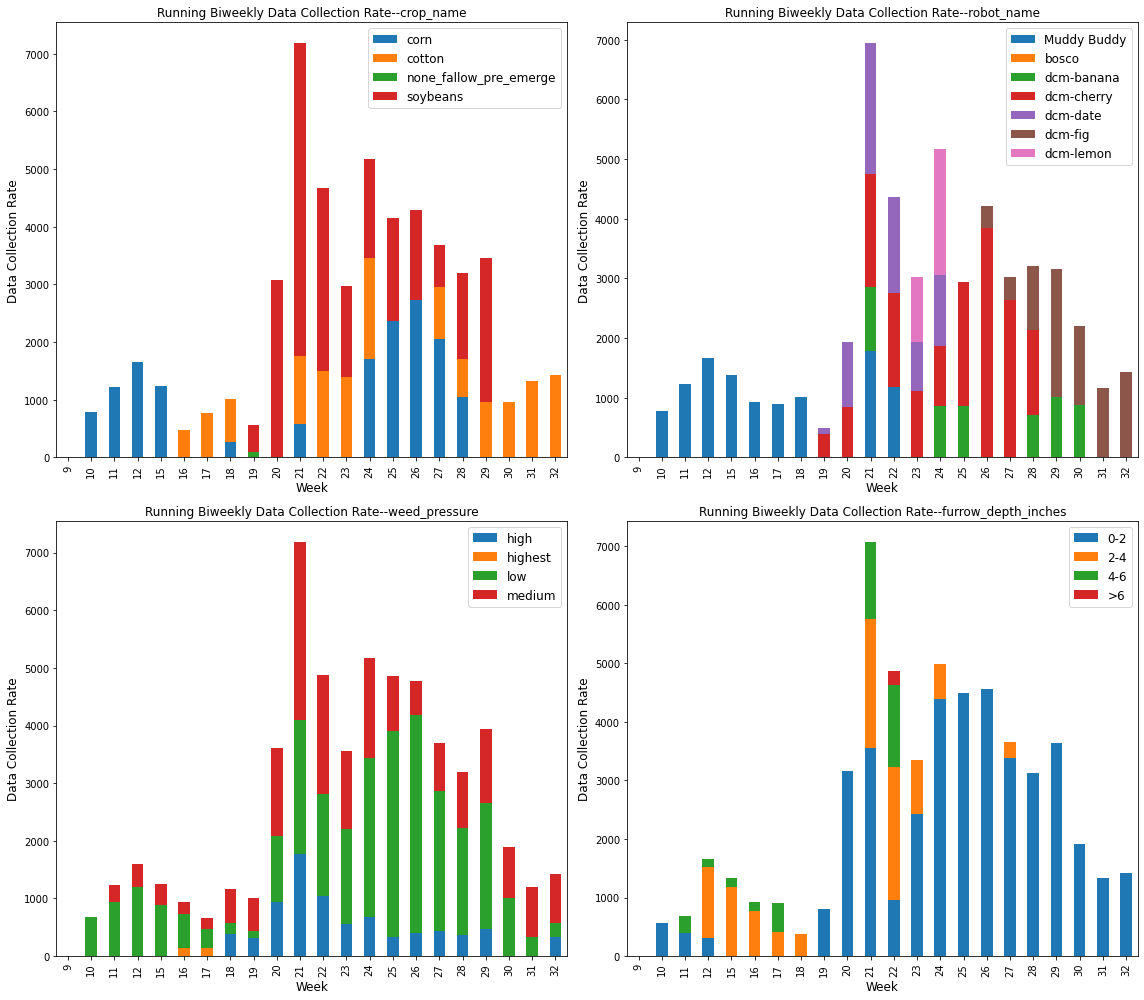

In [14]:
# plot data collection rate and break down them by each feature
feature_columns = ['crop_name','robot_name','weed_pressure','furrow_depth_inches']

fig, axes = plt.subplots(2,2,figsize=(16,14))
n=0
for x in range(2):
  for y in range(2):
    # since 'unknown' takes a very small proportion of the whole dataset, I will not include unknown
    condition = image_2019[feature_columns[n]] != 'unknown'

    # calculate data collection rate in each week
    stack = image_2019[condition].groupby(['week',feature_columns[n]]).size()

    # aggregate them into a biweekly frequency, and plot out stacked bars
    stack.unstack().rolling(2).sum().plot(kind='bar',stacked=True, ax=axes[x][y])

    axes[x][y].legend(fontsize=12)
    axes[x][y].set_xlabel('Week',fontsize=12)
    axes[x][y].set_ylabel('Data Collection Rate',fontsize=12)
    axes[x][y].set_title('Running Biweekly Data Collection Rate--' + feature_columns[n], fontsize=12)

    n += 1
plt.tight_layout()

In [36]:
image_2019.groupby(['week']).size().rolling(2).sum()

week
9        NaN
10     786.0
11    1228.0
12    1664.0
15    1382.0
16     931.0
17     899.0
18    1236.0
19    1004.0
20    3616.0
21    7190.0
22    4880.0
23    3575.0
24    5178.0
25    4884.0
26    4789.0
27    3691.0
28    3202.0
29    3932.0
30    2204.0
31    1332.0
32    1426.0
dtype: float64

#### Overall Data Collection Rate
As is shown from the above figures, in 2019, the data collection was conducted from week 9 (March) to week 32 (August), with a total of 6 months time length. The overall data collection rate was around 1141 data points biweekly in the first ten weeks (from March to mid-May). The data collection rate surges from week 20 (mid-May) and continues to be relatively high till week 29 (late July), during which the mean biweekly collection rate is 4494.

#### crop_name
In terms of data collection on different crop species, we have mainly collected three species, corn, cotton, and soybean. We have a high data collection on cotton in the beginning (week 9 to week 15) and week 24 to week 27. A high data collection on soybeans from week 20 to week 29.. 

#### Robot
From week 9 to week 18, Muddy Buddy is the main robot in use. From week 24 to 32, there are banana, cherry and fig in use. In the remaining weeks, multiple robots are in use simultaneously.

#### Weed-Pressure

Throughout the data collection, most of the time there is low weed pressure. There was only the highest week pressure that happened during week 16 and week 17 (Mid to Late April).

#### Furrow_depth

For most of the time, furrow_depth is 0-2 inches. There are only week 12 to week 18 (Mid March to early May), and week 21 and 22 (late May and early June), there are relatively high proportions of furrow-depth that were 2-4 inches.

## 3. Geographical Density

To perform geographical analysis and better understand the data, I first transform the 'gps_latitude' and 'gps_longitude' data into address data, and then extract corresponding state, county, and postcode for a further analysis.

To transfrom gps data, I used the geopy package. Since it is not feasible to perform a transformation of ~ 30000 gps data points, I first round the gps data into three decimals to get 1191 unique gps data points. I then used 'geopy' package to transform 1191 gps data into address, and merge it with the original image dataset on the same gps location. A difference of 0.001 degress of latitude and longitude only introduces an error of 100 m.

In [15]:
# round latitude and longitude to only three decimals
image_2019['gps_latitude'] = image_2019['gps_latitude'].round(3)
image_2019['gps_longitude'] = image_2019['gps_longitude'].round(3)

# get 1191 unique latitude and longitude data
image_2019_location = image_2019[['gps_latitude', 'gps_longitude']].groupby(['gps_latitude', 'gps_longitude']).size().reset_index()

In [16]:
# using the geopy package to define a function to transform gps data to address
def get_address(df, geolocator, lat_field, lon_field):
    try:
        location = geolocator.reverse((df[lat_field], df[lon_field]), timeout=10)
        return location.raw['address']
    except (AttributeError, KeyError, ValueError) as e:
        print(repr(e), lat_field, lon_field)
        return None

geolocator = geopy.Nominatim(user_agent='my-application')

# apply the aforementioned function on the unique gps data points
# there are ~ 30 data points were incorrect, which can not be tranformed to address
# I transformed error gps data by hand searching on google and I found those were located in the ocean, therefore, they were wrong
address_temp = image_2019_location.apply(get_address, axis=1, geolocator=geolocator, lat_field='gps_latitude', lon_field='gps_longitude')

KeyError('address') gps_latitude gps_longitude
KeyError('address') gps_latitude gps_longitude
KeyError('address') gps_latitude gps_longitude
KeyError('address') gps_latitude gps_longitude
KeyError('address') gps_latitude gps_longitude
KeyError('address') gps_latitude gps_longitude
KeyError('address') gps_latitude gps_longitude
KeyError('address') gps_latitude gps_longitude
KeyError('address') gps_latitude gps_longitude
KeyError('address') gps_latitude gps_longitude
KeyError('address') gps_latitude gps_longitude
KeyError('address') gps_latitude gps_longitude
KeyError('address') gps_latitude gps_longitude
KeyError('address') gps_latitude gps_longitude
KeyError('address') gps_latitude gps_longitude
KeyError('address') gps_latitude gps_longitude
KeyError('address') gps_latitude gps_longitude
KeyError('address') gps_latitude gps_longitude
KeyError('address') gps_latitude gps_longitude
KeyError('address') gps_latitude gps_longitude
KeyError('address') gps_latitude gps_longitude
KeyError('add

In [17]:
# only extract county, postcode, and state
location_info = address_temp.apply(pd.Series)[['county','postcode','state']]

# concat this dataset with gps data
location = pd.concat([image_2019_location, location_info], axis=1)
location = location[['gps_latitude', 'gps_longitude', 'county', 'postcode', 'state']]

In [18]:
# merge location dataset with the original image dataset
image_2019_withloc = pd.merge(image_2019, location, how='left', on=['gps_latitude', 'gps_longitude'])
image_2019_withloc.head()

,id,collection_date,machine_data,content_hash,image_id,crop_name,robot_name,weed_pressure,furrow_depth_inches,gps_latitude,gps_longitude,date,week,year,county,postcode,state
0,2548046,2019-08-05 20:45:05.115711,"{""ils_nir"": 1142, ""ils_red"": 1896, ""weather"": ...",109d6a4af9a5fc7c21ceee2168063209,2548046,cotton,dcm-fig,high,0-2,32.242,-101.955,2019-08-05,32,2019,Martin County,NaN,Texas
1,3712464,2019-06-10 17:22:05.576691,"{""ils_nir"": 1176, ""ils_red"": 1982, ""weather"": ...",c9ffe3381de6ad8b01853fd62779daef,3712464,cotton,dcm-date,medium,0-2,33.957,-102.600,2019-06-10,24,2019,Lamb County,NaN,Texas
2,4322340,2019-07-11 15:02:04.521867,"{""ils_nir"": 1999, ""ils_red"": 2953, ""weather"": ...",922f5cb720b61d617d97d8471c3063e1,4322340,soybeans,dcm-cherry,low,0-2,0.000,0.000,2019-07-11,28,2019,NaN,NaN,NaN
3,3910126,2019-05-16 20:19:07.538567,"{""ils_nir"": 1531, ""ils_red"": 2554, ""weather"": ...",5d63b064497d24121557f805a6257209,3910126,soybeans,dcm-date,medium,0-2,30.918,-96.724,2019-05-16,20,2019,Robertson County,NaN,Texas
4,3424603,2019-06-21 18:54:55.987010,"{""ils_nir"": 265, ""ils_red"": 477, ""weather"": ""o...",f28f7ea4e4dbb3c7cedab5aed4d9458e,3424603,corn,dcm-cherry,medium,0-2,47.178,-97.515,2019-06-21,25,2019,Cass County,58064,North Dakota


The following two tables gives the locations with the highest data collection density. In terms of states, Texas has the highest data collection rate. There were 39.84% data was collected in Texas. Following are Louisiana and Minnesota, which are 15.28% and 14.44%, respectively.

In the data from Texas, cotton data is the mainstream.

In [19]:
state_stats = image_2019_withloc.groupby('state').size().reset_index()
state_stats.columns = ['state','count']
state_stats['percentage'] = round(state_stats['count']/(state_stats['count'].sum())*100,2)
print('The data collection density of each state are listed as below \n')
state_stats.sort_values(by='count',ascending=False)

The data collection density of each state are listed as below 



,state,count,percentage
18,Texas,11560,39.74
7,Louisiana,4444,15.28
8,Minnesota,4202,14.44
16,South Dakota,2148,7.38
13,North Dakota,1314,4.52
4,Iowa,1193,4.10
0,Arkansas,1143,3.93
12,North Carolina,958,3.29
2,Illinois,578,1.99
9,Mississippi,553,1.90


In [20]:
print('The distribution of data points that were collected in Texas:')
image_2019_withloc[image_2019_withloc['state'] == 'Texas']['crop_name'].value_counts().sort_values(ascending=False)

The distribution of data points that were collected in Texas:


cotton      5407
corn        3555
soybeans    2598
Name: crop_name, dtype: int64

In terms of counties, Cameron County in Texas accounted for 11.43% of the whole data collection, which is the highest data collection proportion among the 242 counties.

In [21]:
county_stats = image_2019_withloc.groupby(['state','county']).size().reset_index()
county_stats.columns = ['state','county','count']
county_stats['percentage'] = round(county_stats['count']/(county_stats['count'].sum())*100,2)
print('The top 15 counties that have the highest data collection density are listed as below \n')
county_stats.sort_values(by='count',ascending=False).head(15)

The top 15 counties that have the highest data collection density are listed as below 



,state,county,count,percentage
165,Texas,Cameron County,3326,11.43
48,Louisiana,Morehouse Parish,2387,8.21
214,Texas,Robertson County,1965,6.75
49,Louisiana,Richland Parish,1187,4.08
61,Minnesota,Goodhue County,1069,3.67
8,Arkansas,Mississippi County,929,3.19
186,Texas,Hockley County,849,2.92
174,Texas,Fannin County,821,2.82
147,South Dakota,Tripp County,812,2.79
159,Texas,Bailey County,781,2.68


In [22]:
# fig, axes = plt.subplots(figsize=(10,8))
# image_2019_withloc.groupby(['week','state']).size().unstack().plot(kind='bar',stacked=True, ax=axes)

# axes.legend(fontsize=12)
# axes.set_xlabel('Week',fontsize=12)
# axes.set_ylabel('Data Collection Rate',fontsize=12)
# axes.set_title('Weekly Data Collection Rate in Various States', fontsize=12)


# plt.legend(bbox_to_anchor=(1.25, 0.9))

In [23]:
# fig, axes = plt.subplots(figsize=(10,8))
# image_2019_withloc[image_2019_withloc['state']=='Minnesota'].groupby(['week','county']).size().unstack().plot(kind='bar',stacked=True, ax=axes)

# axes.legend(fontsize=12)
# axes.set_xlabel('Week',fontsize=12)
# axes.set_ylabel('Data Collection Rate',fontsize=12)
# axes.set_title('Weekly Data Collection Rate in Various States', fontsize=12)


# plt.legend(bbox_to_anchor=(1.25, 0.9))

## 4. Annotation Progress
In this section, I first pre-process the annotation dataset and then merge it with the image dataset to evaluate annotation progress.

In [24]:
# transform date, and extract year, month and week
annotation['creation_date'] = pd.to_datetime(annotation['creation_date'])
annotation['year'] = annotation['creation_date'].dt.year
annotation['month'] = annotation['creation_date'].dt.month
annotation['week'] = annotation['creation_date'].dt.week

annotation_2019 = annotation[annotation['year'] == 2019]

In [25]:
# merge image_2019 with annotation_2019 on the same image_id
anno_progress = pd.merge(image_2019_withloc, annotation_2019, on='image_id', suffixes=('_image', '_anno'))
anno_progress['collection_date'] = pd.to_datetime(anno_progress['collection_date'])
anno_progress.head()

,id_image,collection_date,machine_data,content_hash,image_id,crop_name,robot_name,weed_pressure,furrow_depth_inches,gps_latitude,gps_longitude,date,week_image,year_image,county,postcode,state,id_anno,creation_date,updated_date,bounding_boxes,style,review_state,project_id,year_anno,month,week_anno
0,1200320,2019-04-15 20:27:17.221000,"{""id"": 416231, ""state"": null, ""county"": null, ...",0ed63b82f837f7a8fe72e532bf29b33a,1200320,cotton,Muddy Buddy,low,2-4,26.277,-97.722,2019-04-15,16,2019,Cameron County,78553,Texas,1200320,2019-11-08 02:54:27.292972,NaN,NaN,pixelwise,ok,1,2019,11,45
1,151805,2019-05-14 18:09:44.014370,"{""ils_nir"": 418, ""ils_red"": 719, ""weather"": ""p...",d1c571e6b1ce8fef18366d4525ff357e,151805,soybeans,dcm-date,high,0-2,30.883,-96.657,2019-05-14,20,2019,Robertson County,NaN,Texas,151805,2019-07-01 07:41:30.000087,2019-08-28 03:59:11.255282,NaN,pixelwise,relabel,1,2019,7,27
2,1240340,2019-04-11 16:29:35.004000,"{""id"": 426266, ""state"": null, ""county"": null, ...",5de810e42fff2dc57f73598a02f1d3a2,1240340,corn,Muddy Buddy,low,2-4,26.317,-97.894,2019-04-11,15,2019,Hidalgo County,78562,Texas,1240340,2019-11-10 01:37:41.289378,NaN,NaN,pixelwise,ok,1,2019,11,45
3,1414685,2019-03-07 20:08:10.580000,"{""id"": 469865, ""state"": null, ""county"": null, ...",bad7753fbaf98c12c283ae4ae8508d15,1414685,corn,Muddy Buddy,medium,4-6,26.310,-97.678,2019-03-07,10,2019,Cameron County,78550,Texas,1414685,2019-11-22 22:08:10.042615,NaN,NaN,pixelwise,ok,1,2019,11,47
4,1083430,2019-05-28 15:10:27.692000,"{""id"": 352770, ""state"": null, ""county"": null, ...",ee0259b103a2aff0098972c38558b949,1083430,cotton,Muddy Buddy,low,0-2,32.353,-91.914,2019-05-28,22,2019,Richland Parish,71269,Louisiana,1083430,2019-11-02 09:09:32.487108,NaN,NaN,pixelwise,ok,1,2019,11,44


In [26]:
# there are four kinds of review status
anno_progress['review_state'].unique()

array(['ok', 'relabel', 'review', 'vendor_review'], dtype=object)

I created an anno_interval feature to track how long it usually take from data collection to data annotation. There are 168 valid data points. The mean interval was 162 days, with a standard deviation of 69 days.

In [27]:
# anno_interval = annotation creation date - image collection data
anno_progress['anno_interval'] = (anno_progress['creation_date']-pd.to_datetime(anno_progress['collection_date'])).dt.days
anno_progress[anno_progress['anno_interval']>0].anno_interval.describe()

count    168.000000
mean     161.690476
std       69.020951
min        2.000000
25%      133.750000
50%      174.000000
75%      212.000000
max      269.000000
Name: anno_interval, dtype: float64

The below figure shows the date distribution of image collection and image annotation. It is clear to see that that image collection was mainly around March and June. Image annotation was mainly around November. 

Text(0.5, 0, 'Date')

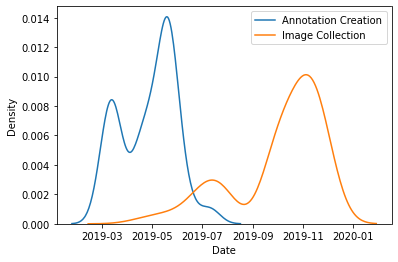

In [28]:
fig, axes = plt.subplots()
sns.kdeplot(data=anno_progress, x='collection_date', label='Annotation Creation')
sns.kdeplot(data=anno_progress, x='creation_date', label='Image Collection')

axes.legend()
axes.set_xlabel('Date')

In [37]:
review_percentage = round(len(anno_progress)/len(image_2019_withloc)*100,2)
ok_review_rate = round(sum(anno_progress['review_state']=='ok')/len(anno_progress)*100, 2)
relabel_rate = round(sum(anno_progress['review_state']=='relabel')/len(anno_progress)*100, 2)
print('Among all the collected images, the percentage of annotaion is ', review_percentage, '%. \n')
print('Among reviewed annotations, the percentage of OK innotaion is ', ok_review_rate, '%. \n')
print('Among reviewed annotations, the percentage of relabel innotaion is ', relabel_rate, '%. \n')

Among all the collected images, the percentage of annotaion is  0.57 %. 

Among reviewed annotations, the percentage of OK innotaion is  73.1 %. 

Among reviewed annotations, the percentage of relabel innotaion is  4.68 %. 



## 5. Increasing Cotton Data Collection by 2?

There are not enough contexts for me to understand the affecting parameters of data collection rate, and the meanings of 'using the same resources and same time', since the same resources and time could mean the same number and consistent performance of robots, same locations, areas, and types of farming land that we could collect data, etc.
Therefore, I made several assumptions in the following analysis, and some of the hypotheses should be verified before a conclusion/decision.
<br>

* I hypothesis we can only use the same number and kinds of robots;
* There are always enough farming lands to collect data. We always have enough machines/robots to collect data.
* The data collection rate is not affected by sampling locations, weed pressure, and furrow-depth.
* Among those states of corn and soybeans data collection, there are Texas, California, Louisiana, Arkansas, Mississippi, North Carolina, Oklahoma, Tennessee are the main cotton production states. I assume I can divert those efforts on collection corn and soybeans data in those states into collection cotton data.


In [30]:
image_cotton = image_2019_withloc[image_2019_withloc['crop_name'] == 'cotton']
image_corn = image_2019_withloc[image_2019_withloc['crop_name'] == 'corn']
image_soybeans = image_2019_withloc[image_2019_withloc['crop_name'] == 'soybeans']

In [31]:
# 27% of data collection is cotton
cotton_percentage = round(len(image_cotton)/len(image_2019_withloc), 2)
cotton_percentage

0.27

In [32]:
for crop in ['cotton', 'corn', 'soybeans']:
  condition = image_2019_withloc['crop_name'] == crop 
  state = image_2019_withloc[condition].groupby('state').size().reset_index()
  state.columns = ['state','count']
  state['percentage'] = round(state['count']/(state['count'].sum())*100,2)
  print('The ',crop, ' data collection density of each state are listed as below \n')
  print(state.sort_values(by='count',ascending=False))

The  cotton  data collection density of each state are listed as below 

            state  count  percentage
9           Texas   5407       68.18
3       Louisiana   1206       15.21
6  North Carolina    454        5.73
0        Arkansas    363        4.58
5        Missouri    246        3.10
4     Mississippi    236        2.98
8       Tennessee      7        0.09
7        Oklahoma      5        0.06
2          Kansas      4        0.05
1        Illinois      2        0.03
The  corn  data collection density of each state are listed as below 

             state  count  percentage
13           Texas   3555       40.41
6        Minnesota   2400       27.28
12    South Dakota    891       10.13
4             Iowa    643        7.31
2         Illinois    376        4.27
10    North Dakota    288        3.27
8         Nebraska    162        1.84
14         Vermont    119        1.35
0         Arkansas    110        1.25
5        Louisiana     99        1.13
9   North Carolina     91      

By hand calculating, I can divert 43.93% of corn data collection and 58.17% of soybeans data collection to cotton. Since there are 31% of data was corn and 42% data was soybean in 2019, therefore there are 43.93% * 31% + 58.17% * 42% = 38% of whole data collection can be turned into cotton.<br>
Therefore, we could turn an extra 38% of data collection into cotton, which can make it double. <br><br>
However, as I mentioned before, I made several assumptions in the following analysis, and some of the hypotheses should be definitely verified before a conclusion/decision. If more contexts of data collection can be provided, a more accurate prediction can be made.